## To do:
* monthly mean vs daily
* detrend data compare
* remove offset from climate projections
* check resolution


In [67]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import run
import func

## Get data

In [78]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])


In [79]:
# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [80]:
np.shape(lai_data)

(8766, 22, 22)

In [90]:
gridcells =[]
for lat in range(len(P_data.lat)):
        for lon in range(len(P_data.lon)):
                if np.isnan(lai_data[:, lat, lon]).all():
                    gridcells.append((lat,lon))

In [94]:
# Specify the latitude and longitude indices of the cell to delete
lat_index = 0  # Example latitude index
lon_index = 0  # Example longitude index

# Delete the cell from P_data
lai_data_filtered = np.delete(lai_data, lat_index, axis=1)
lai_data_filtered = np.delete(lai_data_filtered, lon_index, axis=2)

In [85]:
for i in gridcells:
    lat_index = i[0]  # Example latitude index
    lon_index = i[1]  # Example longitude index

    # Create a boolean mask for the cells to delete
    mask = (P_data.lat == P_data.lat[lat_index]) & (P_data.lon == P_data.lon[lon_index])

    # Filter data using the mask
    P_data_filtered = P_data.where(~mask, drop=True)
    R_data_filtered = R_data.where(~mask, drop=True)
    T_data_filtered = T_data.where(~mask, drop=True)
    lai_data_filtered = lai_data.where(~mask, drop=True)

ValueError: Dimensions {'lon', 'lat'} do not exist. Expected one or more of Frozen({'time': 8766, 'latitude': 22, 'longitude': 22})

In [81]:
# Find grid cells where all LAI values are NaN
lai_nan_mask = np.isnan(lai_data).all(axis=0)

# Convert boolean mask to indices
indices = np.where(~lai_nan_mask)

# Use the indices to select the corresponding cells from other data arrays
P_data_filtered = P_data[:, indices[0], indices[1]]
R_data_filtered = R_data[:, indices[0], indices[1]]
T_data_filtered = T_data[:, indices[0], indices[1]]
lai_data_filtered = lai_data[:, indices[0], indices[1]]

MemoryError: Unable to allocate 13.0 GiB for an array with shape (8766, 447, 447) and data type float64

In [75]:
lai_nan_mask = np.isnan(lai_data).all(axis=0)

In [77]:
lai_nan_mask 

<xarray.DataArray 'lai' (latitude: 22, longitude: 22)>
array([[ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False,  True, False,
        False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
...
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
        False, False, False, False]])
Coordinates:
  * latitude   (latitude) float64 55.25 54.75 54.25 53.75 ... 45.75 45.25 44.75
  * longitude  (longitude) float64 4.75 5.25 5.75 6.25 ... 14.25 14.75 15.25

In [74]:
np.shape(P_data_filtered)

(8766, 447, 447)

In [53]:
# Fill LAI with zeros were Na :D (wrong)
lai_data = lai_data.fillna(0)

## Run model for daily values

In [54]:
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]

In [6]:
output_daily = func.grid_model(P_data, R_data, T_data, lai_data, params, cell = False)

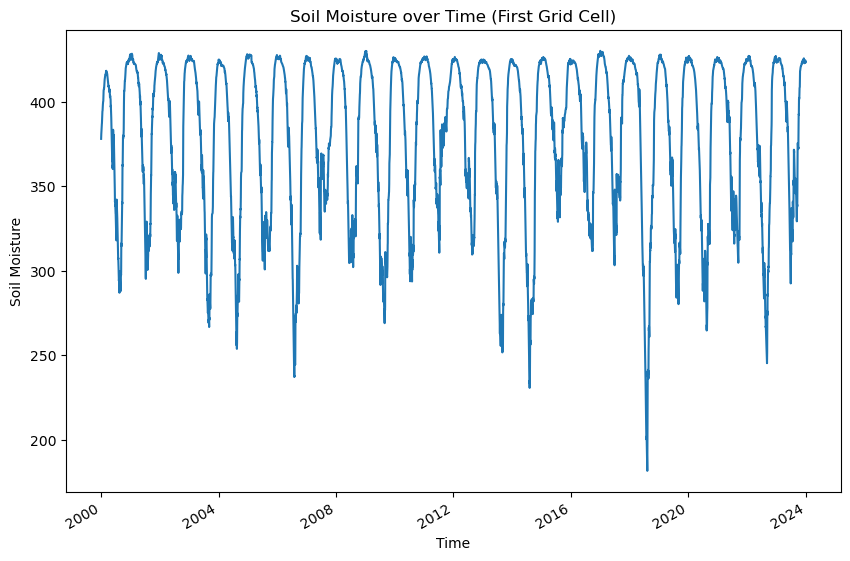

In [9]:
plt.figure(figsize=(10, 6))
output_daily['soil_moisture'].isel(lat=0, lon=0).plot(x='time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture over Time (First Grid Cell)')
plt.show()

## Run model on monthly data

In [55]:
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

In [56]:
# Sort lai data

# Calculate monthly means
P_monthly = P_data.resample(time='1M').mean(dim='time')
R_monthly = R_data.resample(time='1M').mean(dim='time')
T_monthly = T_data.resample(time='1M').mean(dim='time')
lai_monthly = lai_data.resample(time='1M').mean(dim='time')

In [59]:
output_monthly = func.grid_model(P_monthly, R_monthly, T_monthly, lai_monthly, params, cell = True)

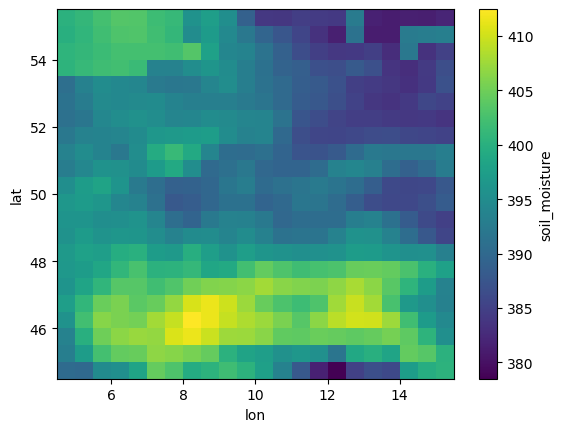

In [61]:
output_monthly['soil_moisture'].max(dim='time').plot()

In [66]:
# Save as csv
#output_monthly_df = output_monthly.to_dataframe()
#output_monthly_df.to_csv("results/monthly_lai_0.csv")